In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [3]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [4]:
image, label = train_data[0]

In [5]:
image.shape

torch.Size([1, 28, 28])

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

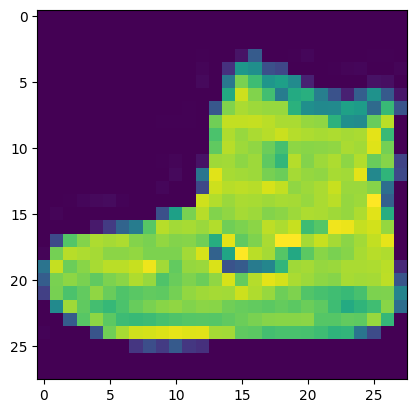

In [7]:
plt.imshow(image.squeeze())

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


In [9]:
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x298775150>, <torch.utils.data.dataloader.DataLoader object at 0x298713b80>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

output

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [13]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)
    
    

In [14]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names))
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [16]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [17]:
device = "cpu"

from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [19]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()


epochs = 3


for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    
    train_loss = 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        
        y_pred = model_0(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:02<00:04,  2.37s/it]


Train loss: 0.44395 | Test loss: 0.46506, Test acc: 83.65%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:04<00:02,  2.33s/it]


Train loss: 0.43662 | Test loss: 0.46453, Test acc: 83.89%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:06<00:00,  2.32s/it]


Train loss: 0.43045 | Test loss: 0.46594, Test acc: 83.93%

Train time on cpu: 6.963 seconds


In [21]:
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [22]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [23]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(784, 10, len(class_names)).to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

In [24]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [25]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [26]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%


 33%|███▎      | 1/3 [00:08<00:16,  8.23s/it]

Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78097 | Train accuracy: 71.94%


 67%|██████▋   | 2/3 [00:15<00:07,  7.76s/it]

Test loss: 0.72611 | Test accuracy: 73.99%

Epoch: 2
---------
Train loss: 0.67040 | Train accuracy: 75.94%


100%|██████████| 3/3 [00:23<00:00,  7.75s/it]

Test loss: 0.69007 | Test accuracy: 74.81%

Train time on mps: 23.246 seconds


In [27]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6900656223297119,
 'model_acc': 74.810303514377}

In [28]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [29]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing

In [30]:
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)


In [32]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59601 | Train accuracy: 78.45%


 33%|███▎      | 1/3 [00:10<00:21, 10.99s/it]

Test loss: 0.39751 | Test accuracy: 85.78%

Epoch: 1
---------
Train loss: 0.36561 | Train accuracy: 86.83%


 67%|██████▋   | 2/3 [00:20<00:10, 10.35s/it]

Test loss: 0.34971 | Test accuracy: 87.15%

Epoch: 2
---------
Train loss: 0.32694 | Train accuracy: 88.25%


100%|██████████| 3/3 [00:30<00:00, 10.24s/it]

Test loss: 0.32853 | Test accuracy: 87.86%

Train time on mps: 30.726 seconds


In [33]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32852885127067566,
 'model_acc': 87.8594249201278}